# Nested cross-validation

In the previous example, we found out how we can test how a specific set of hyparameters works on a test dataset. If we want to know how each set of possible hyperparameters works, we could test each of these individually.

:::{danger}
Once we have used a set of documents to optimize anything, it is no longer a valid test dataset. We can no longer use this data to estimate our model's performance on new data.
:::

The reason is that we are in danger of **overfitting**, or over-optimizing for our specific test dataset, at the expense of generalisability on new data.

## Train, Validation, Test data

To avoid this, we need to split the data further. We end up with

- *Training Data*: This is used to train models and model specifications
- *Validation Data*: This is used to find out which model specification we think works best
- *Testing Data*: This is used to test the model we think works best and estimate its performance on new data

Each data point should only ever appear in one of these.

Let's see a simplified example. First we need to split our data.

In [1]:
import os
os.chdir('../../../')

params = {
  "per_device_train_batch_size": [16, 32],
  "learning_rate": [5e-5, 3e-5, 2e-5],
  "num_train_epochs": [2,3,4]
}

import itertools
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))
param_list = list(product_dict(**params))

In [2]:
from sklearn.model_selection import train_test_split
import random
import numpy as np

# Let's imagine we have a dataset with 100 documents
idx = np.arange(100)

# split our whole data into train and test sets
train_idx, test_idx = train_test_split(idx, shuffle=False)
# set aside some validation by removing from training data
sub_train_idx, val_idx = train_test_split(train_idx, shuffle=False)

We can visualise these splits with coloured dots, where each dot represents a paper.

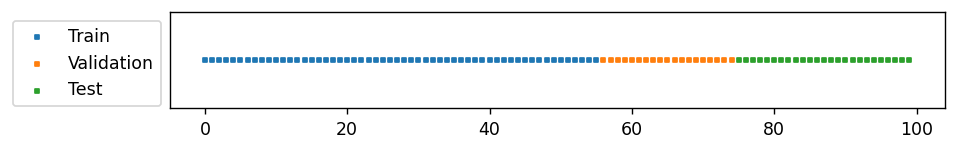

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=125, figsize=(8,1))

s = 3
ax.scatter(
    sub_train_idx, [0]*sub_train_idx.size,
    color="C0", s=s, label="Train",
    marker="s"
)
ax.scatter(
    val_idx, [0]*val_idx.size,
    color="C1", s=s, label="Validation",
    marker="s"
)
ax.scatter(
    test_idx, [0]*test_idx.size,
    color="C2", s=s, label="Test",
    marker="s"
)
ax.set_yticks([])
ax.legend(bbox_to_anchor=(0,1))
plt.show()

Simplified code to find the parameters that work best on our validation data would look like this

:::{attention}
For illustrative purposes, in each the following examples we will simply make up
random values when "evaluating" models. The train and eval functions are simply stand-ins to show the process
:::

In [4]:
# Our train function would train a model withing parameters p on data train_idx
def train(p, train_idx):
    return None

# Our eval function would calculate the f1 score for model predictions for our validation/test data
def eval(model, val_idx):
    return random.random() # here we simply return a random number

scores = []
# loop through our different parameter settings
for p in param_list:
    # Train a model with these parameters on the training data
    model = train(p, sub_train_idx)
    # Evaluate this model on the validation data
    scores.append(eval(model, val_idx))

# Now we can find the set of parameters which had the best score
top_idx = np.argmax(scores)
best_params = param_list[top_idx]
print(best_params)
print(f'F1 score {scores[top_idx]}')

{'per_device_train_batch_size': 16, 'learning_rate': 2e-05, 'num_train_epochs': 3}
F1 score 0.9638139264258877


Once we have found our best set of parameters, we can train our final model on both train and validation data, and evaluate it on our test data

In [5]:
model = train(best_params, train_idx)
f1_estimate = eval(model, test_idx)
print(f1_estimate)

0.9532916594290585


## Cross-validation

Each time we sample data, a random element of noise creeps into our process.
To reduce the influence of random noise, we can employ cross-validation in order make our process more robust.

One way of doing this, is to split training dataset into multiple train-validation splits

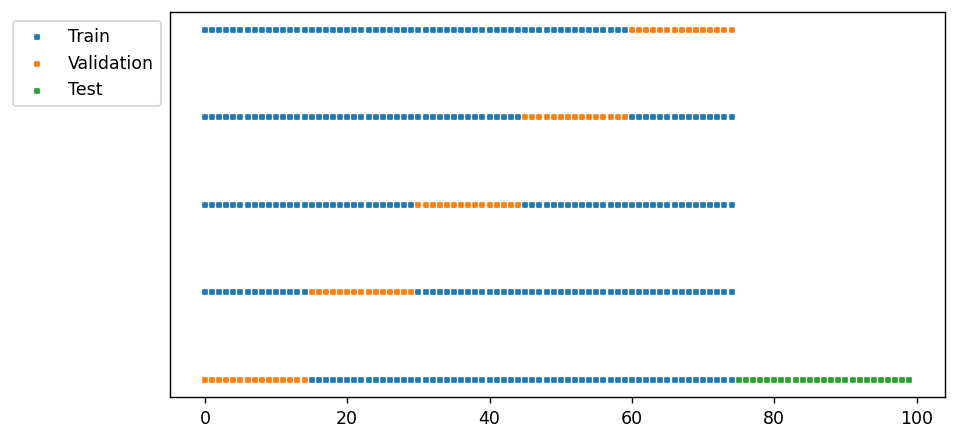

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=125, figsize=(8,4))

from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k)

for i, (sub_train_idx, val_idx) in enumerate(kf.split(train_idx)):

    ax.scatter(
        train_idx[sub_train_idx], [i]*sub_train_idx.size,
        color="C0", s=s, label="Train" if i == 0 else "",
        marker="s"
    )
    ax.scatter(
        train_idx[val_idx], [i]*val_idx.size,
        color="C1", s=s, label="Validation" if i == 0 else "",
        marker="s"
    )

ax.scatter(
    test_idx, [0]*test_idx.size,
    color="C2", s=s, label="Test",
    marker="s"
)
ax.set_yticks([])
ax.legend(bbox_to_anchor=(0,1))
plt.show()

ax.set_yticks([])
ax.legend(bbox_to_anchor=(0,1))
plt.show()

Each split of training data into training and validation sets is called a **fold**, hence [k-fold cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

To find our best model using k-fold cross-validation, we will evaluate each set of parameters on each fold. Then we will select the set of parameters that achieved the highest f1-score *on average* across the folds.

Simplified code that explains this process looks like this:

In [7]:

scores = np.empty((len(param_list), k))

kf = KFold(n_splits=k)


# loop through our different parameter settings
for i, p in enumerate(param_list):
    # loop through each split
    for j, (sub_train_idx, val_idx) in enumerate(kf.split(train_idx)):
        # Train a model with these parameters on the training data
        model = train(p, train_idx[sub_train_idx])
        # Evaluate this model on the validation data
        scores[i,j] = eval(model, train_idx[val_idx])

# Now we can find the set of parameters which had the best score averaged across splits
mean_scores = scores.mean(axis=1)
top_idx = np.argmax(mean_scores)
best_params = param_list[top_idx]
print(best_params)
print(f'F1 score {mean_scores[top_idx]}')

{'per_device_train_batch_size': 32, 'learning_rate': 2e-05, 'num_train_epochs': 2}
F1 score 0.6633841123771107


Once again, we can evaluate this best model against our test data.

You will notice though, that we need to train and evaluate `k` times as many models

### Nested cross-validation

However, our test dataset is still only one sample from  many different possible samples. If we had picked a different sample, our evaluation score may have been different.

**Nested cross-validation** allows us to use each labelled document we have once, making our estimate of generalisation performance less susceptible to random noise.

This is particularly useful when we have limited amounts of labelled data (with a sufficiently large test dataset this is not really necessary). However, it increases computational requirements once more.

With nested CV, we have two folds: an outer fold, and an inner fold. These are split up as follows.

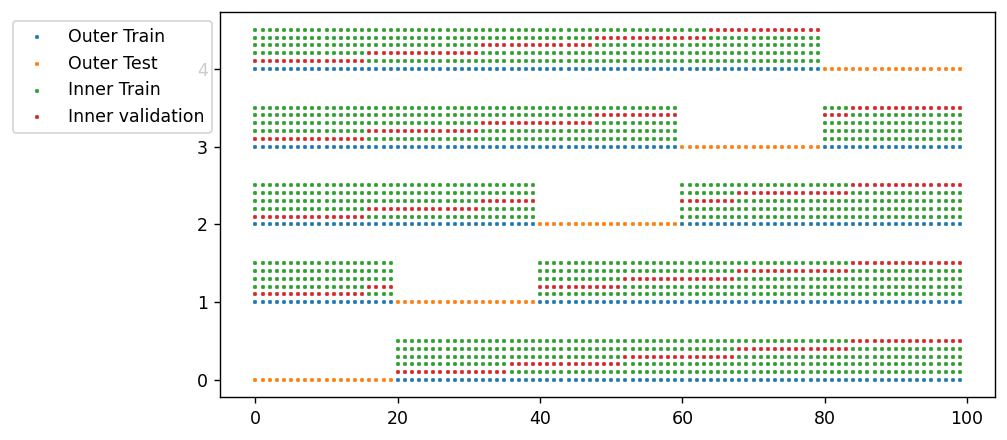

In [8]:
fig, ax = plt.subplots(dpi=125, figsize=(8,4))
outer_fold = KFold(k)
for i, (outer_train_idx, test_idx) in enumerate(outer_fold.split(idx)):
    ax.scatter(
        outer_train_idx, [i]*outer_train_idx.size,
        color="C0", s=2, label="Outer Train" if i == 0 else "",
        marker="s"
    )
    ax.scatter(
        test_idx, [i]*test_idx.size,
        color="C1", s=2, label="Outer Test" if i == 0 else "",
        marker="s"
    )
    inner_fold = KFold()
    for j, (inner_train_idx, inner_validation_idx) in enumerate(inner_fold.split(outer_train_idx)):
        ax.scatter(
            outer_train_idx[inner_train_idx], [i+(j+1)*0.1]*inner_train_idx.size,
            color="C2", s=2, label="Inner Train" if i+j == 0 else "",
            marker="s"
        )
        ax.scatter(
            outer_train_idx[inner_validation_idx], [i+(j+1)*0.1]*inner_validation_idx.size,
            color="C3", s=2, label="Inner validation" if i+j == 0 else "",
            marker="s"
        )

ax.set_yticks(np.arange(i+1))
ax.legend(bbox_to_anchor=(0,1))
plt.show()

We simply repeat the cross-validation process we saw before `k` times, each time assessing the model we find best on a different outer test set.

We will end up with `k` separate estimates of our f1 score. We can report the mean of these, with the standard deviation indicating how much this estimate varies across different test sets.

#### Final model

However, if we follow the process above, we end up with 5 best models, each of which may have a different set of hyperparameters.

In order to calculate our final model, we need to do one more pass through the outer folds, training a model for each set of hyperparameters on each outer train dataset, and evaluating on each outer test dataset. The model that achieves the best score across those test datasets is the one we will use.

:::{attention}
Our final model may end up different from some or all of the models we used to estimate our f1 score. What we are doing is not evaluating the model itself but the *model selection procedure*
:::

In the next section we will find out how to make this process more efficient